# Final Project

1. EDA
2. SVM

## 1. EDA

In [2]:
# packages
library(dplyr)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(e1071)
library(ROCR)

In [8]:
# data loading
data <- read.csv("hcv.csv") %>% 
                # delete id
                select(-X) %>%
                # remove "0s=suspect Blood Donor"
                filter(Category != "0s=suspect Blood Donor") %>%
                mutate(Category = case_when(Category == "0=Blood Donor" ~ "BD",
                                            Category == "1=Hepatitis" ~ "H",
                                            Category == "2=Fibrosis" ~ "F",
                                            Category == "3=Cirrhosis" ~ "C"),
                       Category = as.factor(Category),
                       Sex = as.factor(ifelse(Sex == "m", 0, 1))) %>% 
                na.omit()

In [9]:
table(data$Category)


 BD   C   F   H 
526  24  12  20 

Very imbalanced sample sizes among all groups of HCV staging.

In [50]:
# summary of this dataset
summary(data)

 Category      Age       Sex          ALB             ALP        
 0:526    Min.   :23.0   0:357   Min.   :23.00   Min.   : 11.30  
 1: 20    1st Qu.:39.0   1:225   1st Qu.:39.00   1st Qu.: 52.50  
 2: 12    Median :47.0           Median :41.95   Median : 66.00  
 3: 24    Mean   :47.3           Mean   :41.83   Mean   : 67.65  
          3rd Qu.:54.0           3rd Qu.:45.17   3rd Qu.: 79.30  
          Max.   :77.0           Max.   :82.20   Max.   :416.60  
      ALT              AST              BIL              CHE        
 Min.   :  0.90   Min.   : 12.00   Min.   :  1.80   Min.   : 1.420  
 1st Qu.: 16.32   1st Qu.: 21.43   1st Qu.:  5.30   1st Qu.: 6.950  
 Median : 22.50   Median : 25.60   Median :  7.15   Median : 8.265  
 Mean   : 25.67   Mean   : 33.33   Mean   : 11.09   Mean   : 8.212  
 3rd Qu.: 31.75   3rd Qu.: 31.60   3rd Qu.: 11.00   3rd Qu.: 9.565  
 Max.   :118.10   Max.   :324.00   Max.   :209.00   Max.   :16.410  
      CHOL            CREA              GGT            

### EDA - Continuous Variables

In [10]:
# extract only continuous variables & category
continuous <- data %>%
                select_if(is.numeric)
continuous <- cbind(continuous, Category = data[,1])

# arrays for boxplots
bps <- vector("list", ncol(continuous)-1)

In [69]:
# produce boxplots
for(i in 1:(ncol(continuous)-1)){
    bp <- continuous[,c(i, ncol(continuous))]
    var <- colnames(bp)[1]
    liver_bp <- continuous[,c(i, ncol(continuous))] %>%
                        gather(key = "variables", value = "value", -Category)

    bps[[i]] <- ggplot(data = liver_bp) + 
                    geom_boxplot(aes(x = Category, y = value)) + 
                    facet_wrap(~ variables, scales = "free", nrow = 1) +
                    labs(x = "Staging", y = var) + theme_bw() +
                    ggtitle(paste0("Boxplot of ", var, "and Staging", sep = "")) +
                    theme(plot.title = element_text(hjust=.5, size=6))
}

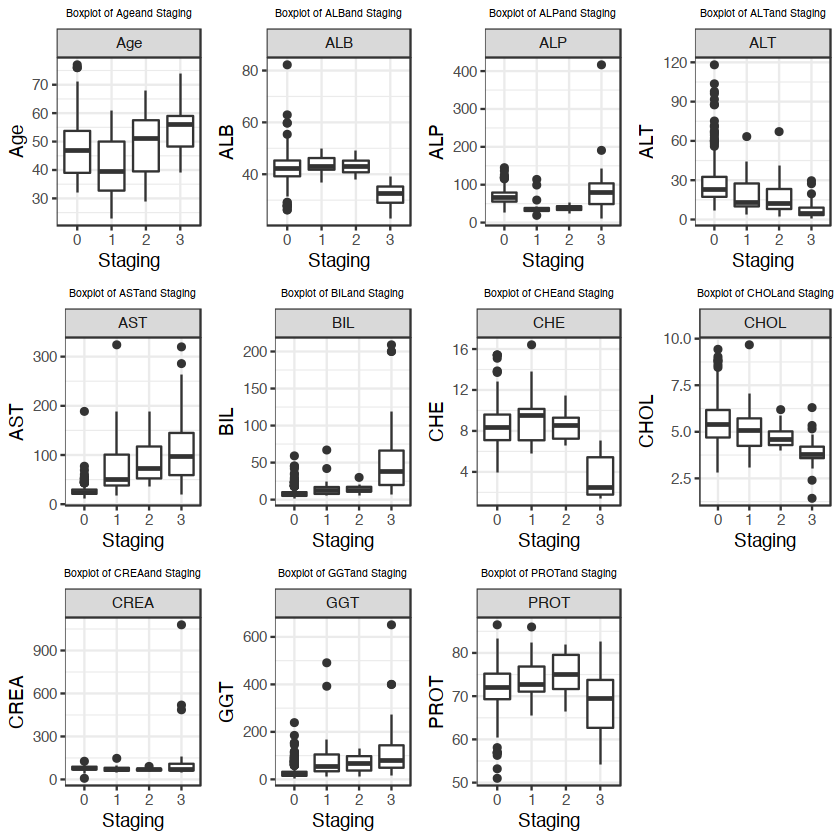

In [72]:
# plot boxplots
options(reper.plot.width = 21, reper.plot.height = 21)
ggarrange(plotlist = bps[1:11], ncol = 4, nrow = 3)

### SVM

## Support Vector Machine

As we did in hw, we are going to use three different kernels for support vector machine classify the level of `staging` of a subject in this analysis. They are `Linear`, `Radial`, , `Polynomial`, and `Sigmoid`. We will first split the whole data set into training and test data. We will use 70% of the whole data for training models.

In [11]:
# randomly sample 70% for the training data set
set.seed(503)
# train dataset
train_x = read.csv("train_x.csv")
train_labels = read.csv("train_labels.csv") %>% 
                    transmute(Category = case_when(V1 == 0 ~ "BD",
                                                   V1 == 1 ~ "H",
                                                   V1 == 2 ~ "F",
                                                   V1 == 3 ~ "C")) %>%
                    mutate(Category = as.factor(Category))                            
# test dataset
test_x = read.csv("test_x.csv")
test_labels = read.csv("test_labels.csv") %>% 
                    transmute(Category = case_when(V1 == 0 ~ "BD",
                                                   V1 == 1 ~ "H",
                                                   V1 == 2 ~ "F",
                                                   V1 == 3 ~ "C")) %>%
                    mutate(Category = as.factor(Category))   

In [12]:
train = data.frame(train_labels, train_x)
test = data.frame(test_labels, test_x)

In [13]:
# class weights
round((nrow(train))/(table(train$Category)*4),1)


 BD   C   F   H 
0.3 5.1 7.2 6.3 

In [126]:
# initial settings
kernels <- c('linear', 'radial', 'polynomial')
cost0 <- c(0.1, 1, 10, 100, 1000)
gamma0 <- c(0.1, 1, 10, 100, 1000)
degree0 <- c(1, 2, 3, 4, 5)
CW <- c('BD' = 0.3, 'C' = 5.1, 'F' = 7.2, 'H' = 6.3)

# vector of lists to store tuning results
tune_result <- vector('list', 3)

# tuning all models with different kernels
for(i in 1:length(kernels)){
  # reproducability
    set.seed(503)
    if(kernels[i] == 'linear'){
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }else if(kernels[i] == 'radial'){
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0, gamma = gamma0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }else{
        tune_result[[i]] = tune(svm, Category ~ ., data = train, kernel = kernels[i],
                                scale = FALSE, range = list(cost = cost0, degree = degree0),
                                class.weights = CW, tunecontrol = tune.control(cross = 5))
    }
}

### Best models for each kernel

In [153]:
# vector of lists to store svm results
best.models <- vector('list', 3)

for(i in 1:length(kernels)){
    hyper = tune_result[[i]]$best.parameters
    if(kernels[i] == 'linear'){
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], class.weights = CW)
    }else if(kernels[i] == 'radial'){
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], gamma = hyper[,2],
                                class.weights = CW)
    }else{
        best.models[[i]] <- svm(Category ~ ., data = train, kernel = kernels[i], 
                                scale = FALSE, cost = hyper[,1], degree = hyper[,2],
                                class.weights = CW)
    }
}

In [246]:
# Prediction & Confusion Matrix: Training dataset
results <- vector('list', length(kernels))
for(i in 1:length(kernels)){
    # array to store results for each model
    a <- array(list(), 2, dimnames = c("train", "test"))
    # training data
    ## prediction
    pred = predict(best.models[[i]], train[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = train$Category)
    ## overall error
    overall = mean(pred == train$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(train$Category), 2)
    a[[1]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   each.class = each.class)
    # test data
    ## prediction
    pred = predict(best.models[[i]], test[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = test$Category)
    ## overall error
    overall = mean(pred == test$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(test$Category), 2)
    a[[2]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   each.class = each.class)
    
    # combine training & test results into 'results' list
    results[[i]] <- a
}

## Results for training

In [265]:
results[[1]][[1]][2:4]; results[[2]][[1]][2:4]; results[[3]][[1]][2:4]

$confusion
       truth
predict  BD   C   F   H
     BD 360   0   0   1
     C    0  21   0   0
     F    0   0  15   0
     H   18   0   0  16

$overall
[1] 0.9559165

$each.class

  BD    C    F    H 
0.95 1.00 1.00 0.94 


$confusion
       truth
predict  BD   C   F   H
     BD 378   0   0   0
     C    0  21   0   0
     F    0   0  15   0
     H    0   0   0  17

$overall
[1] 1

$each.class

BD  C  F  H 
 1  1  1  1 


$confusion
       truth
predict  BD   C   F   H
     BD 378   0   0   0
     C    0  21   0   0
     F    0   0  15   0
     H    0   0   0  17

$overall
[1] 1

$each.class

BD  C  F  H 
 1  1  1  1 


## Results for test

In [266]:
results[[1]][[2]][2:4]; results[[2]][[2]][2:4]; results[[3]][[2]][2:4]

$confusion
       truth
predict  BD   C   F   H
     BD 155   4   2   0
     C    0   4   0   0
     F    0   1   1   3
     H    7   0   3   4

$overall
[1] 0.8913043

$each.class

  BD    C    F    H 
0.96 0.44 0.17 0.57 


$confusion
       truth
predict  BD   C   F   H
     BD 162   9   6   7
     C    0   0   0   0
     F    0   0   0   0
     H    0   0   0   0

$overall
[1] 0.8804348

$each.class

BD  C  F  H 
 1  0  0  0 


$confusion
       truth
predict  BD   C   F   H
     BD 159   3   1   0
     C    1   6   0   0
     F    1   0   3   1
     H    1   0   2   6

$overall
[1] 0.9456522

$each.class

  BD    C    F    H 
0.98 0.67 0.50 0.86 


## SVM with SMOTE

In [282]:
# train dataset : SMOTE
train.x.SMOTE = read.csv("X_train_SMOTE.csv") %>% select(-X)
train.labels.SMOTE = read.csv("Y_train_SMOTE.csv") %>% 
                        transmute(Category = case_when(V1 == 0 ~ "BD",
                                                       V1 == 1 ~ "H",
                                                       V1 == 2 ~ "F",
                                                       V1 == 3 ~ "C")) %>%
                        mutate(Category = as.factor(Category))  
train.SMOTE = data.frame(train.labels.SMOTE, train.x.SMOTE)

In [283]:
# vector of lists to store tuning results
tune_result.SMOTE <- vector('list', 3)

# tuning all models with different kernels
for(i in 1:length(kernels)){
  # reproducability
    set.seed(503)
    if(kernels[i] == 'linear'){
        tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
                                      kernel = kernels[i], scale = FALSE, 
                                      range = list(cost = cost0),
                                      tunecontrol = tune.control(cross = 5))
    }else if(kernels[i] == 'radial'){
        tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
                                      kernel = kernels[i],
                                      scale = FALSE, range = list(cost = cost0, 
                                                                  gamma = gamma0),
                                      tunecontrol = tune.control(cross = 5))
    }else{
        tune_result.SMOTE[[i]] = tune(svm, Category ~ ., data = train.SMOTE, 
                                      kernel = kernels[i],
                                      scale = FALSE, range = list(cost = cost0, 
                                                                  degree = degree0),
                                      tunecontrol = tune.control(cross = 5))
    }
}

In [284]:
# vector of lists to store svm results
best.models.SMOTE <- vector('list', 3)

for(i in 1:length(kernels)){
    hyper = tune_result.SMOTE[[i]]$best.parameters
    if(kernels[i] == 'linear'){
        best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, cost = hyper[,1])
    }else if(kernels[i] == 'radial'){
        best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, 
                                      cost = hyper[,1], gamma = hyper[,2])
    }else{
        best.models.SMOTE[[i]] <- svm(Category ~ ., data = train.SMOTE, probability = TRUE,
                                      kernel = kernels[i], scale = FALSE, 
                                      cost = hyper[,1], degree = hyper[,2])
    }
}

In [278]:
# Prediction & Confusion Matrix: Training dataset
results.SMOTE <- vector('list', length(kernels))
for(i in 1:length(kernels)){
    # array to store results for each model
    a <- array(list(), 2)
    # training data
    ## prediction
    pred = predict(best.models.SMOTE[[i]], train.SMOTE[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = train.SMOTE$Category)
    ## overall error
    overall = mean(pred == train.SMOTE$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(train.SMOTE$Category), 2)
    a[[1]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   each.class = each.class)
    # test data
    ## prediction
    pred = predict(best.models.SMOTE[[i]], test[, -1])
    ## confusion matrix
    confusion = table(predict = pred, truth = test$Category)
    ## overall error
    overall = mean(pred == test$Category)
    ## error for each class
    each.class = round(diag(confusion)/table(test$Category), 2)
    a[[2]] <- list(pred = pred, confusion = confusion, overall = overall, 
                   each.class = each.class)
    
    # combine training & test results into 'results' list
    results.SMOTE[[i]] <- a
}

In [279]:
results.SMOTE[[1]][[1]][2:4]; results.SMOTE[[2]][[1]][2:4]; results.SMOTE[[3]][[1]][2:4]

$confusion
       truth
predict  BD   C   F   H
     BD 367   0   0   2
     C    0 378   0   0
     F    1   0 377   0
     H   10   0   1 376

$overall
[1] 0.9907407

$each.class

  BD    C    F    H 
0.97 1.00 1.00 0.99 


$confusion
       truth
predict  BD   C   F   H
     BD 378   0   0   0
     C    0 378   0   0
     F    0   0 378   0
     H    0   0   0 378

$overall
[1] 1

$each.class

BD  C  F  H 
 1  1  1  1 


$confusion
       truth
predict  BD   C   F   H
     BD 378   0   0   0
     C    0 378   0   0
     F    0   0 378   0
     H    0   0   0 378

$overall
[1] 1

$each.class

BD  C  F  H 
 1  1  1  1 


In [280]:
results.SMOTE[[1]][[2]][2:4]; results.SMOTE[[2]][[2]][2:4]; results.SMOTE[[3]][[2]][2:4]

$confusion
       truth
predict  BD   C   F   H
     BD 155   4   2   0
     C    0   4   0   0
     F    1   1   1   3
     H    6   0   3   4

$overall
[1] 0.8913043

$each.class

  BD    C    F    H 
0.96 0.44 0.17 0.57 


$confusion
       truth
predict  BD   C   F   H
     BD 162   9   6   7
     C    0   0   0   0
     F    0   0   0   0
     H    0   0   0   0

$overall
[1] 0.8804348

$each.class

BD  C  F  H 
 1  0  0  0 


$confusion
       truth
predict  BD   C   F   H
     BD 158   3   1   0
     C    1   5   0   0
     F    1   0   4   1
     H    2   1   1   6

$overall
[1] 0.9402174

$each.class

  BD    C    F    H 
0.98 0.56 0.67 0.86 


# ROC Curves: SMOTE

In [ ]:
library(e1071)
svm.smote.prob <- vector('list', 3)
ROC <- vector('list', 4)

category <- vector("list", 4)
variable <- c("BD", "H", "F", "C")
for(i in 1:4){
    category[[i]] <- data.frame(Category = test$Category) %>% 
                        mutate(Category = ifelse(Category == variable[i], 1, 0))}

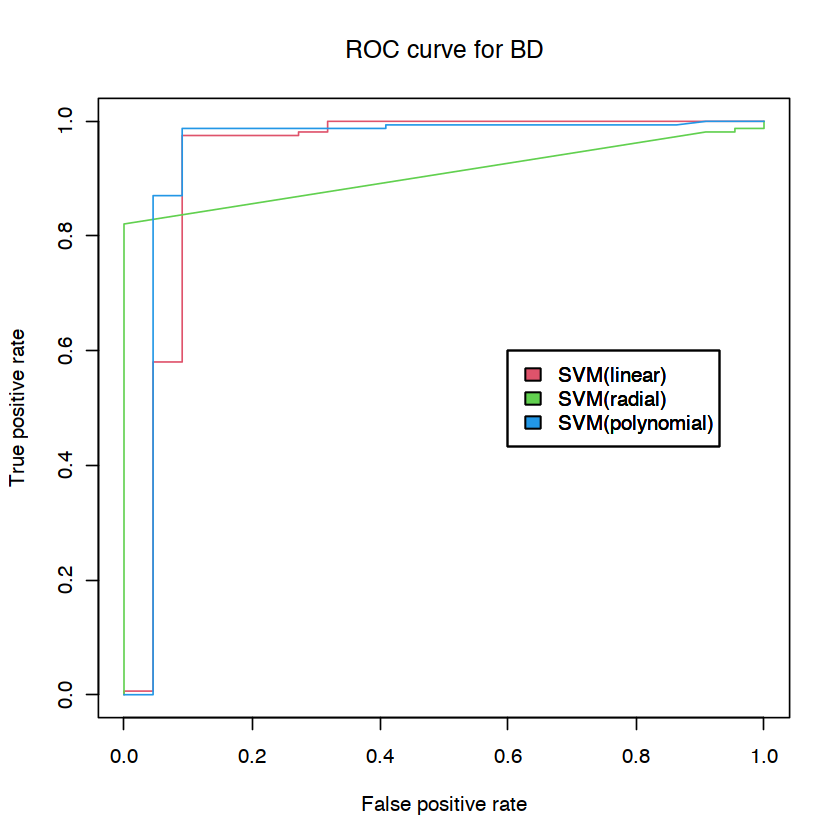

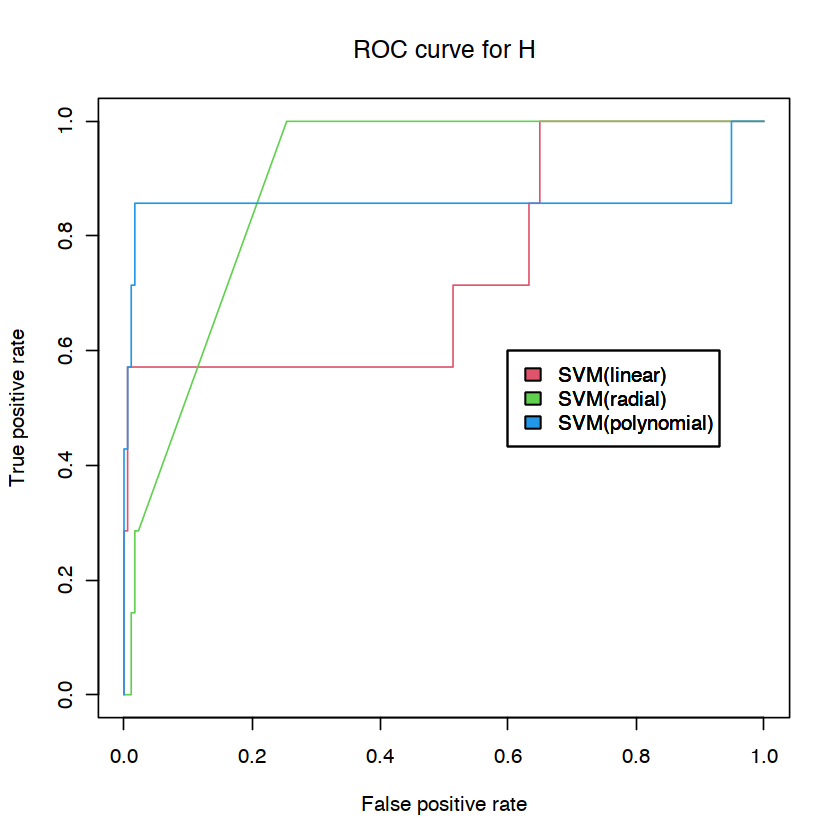

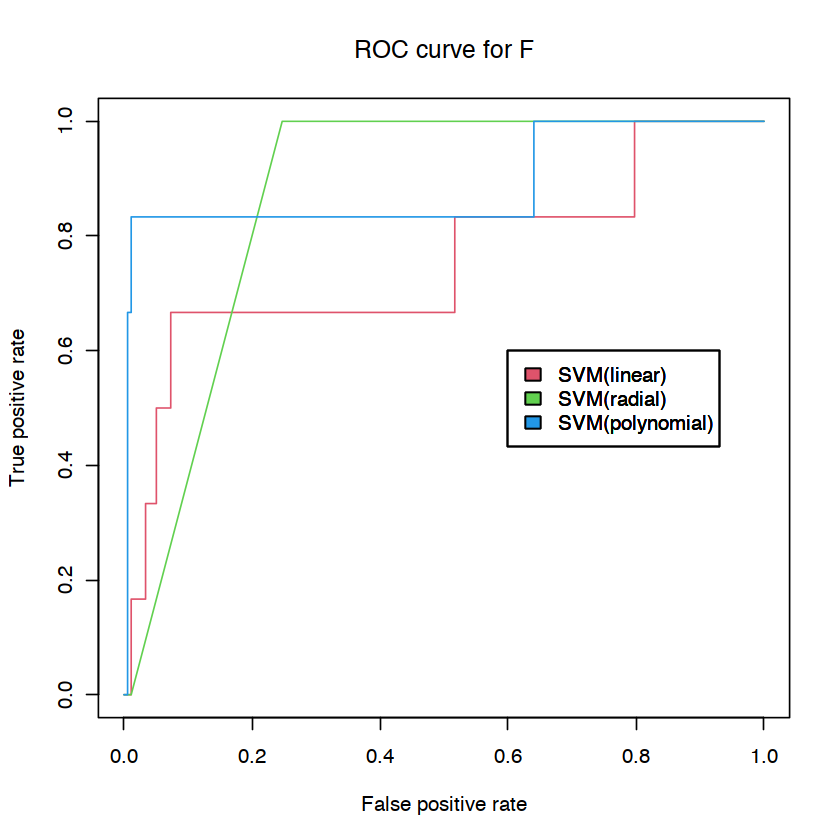

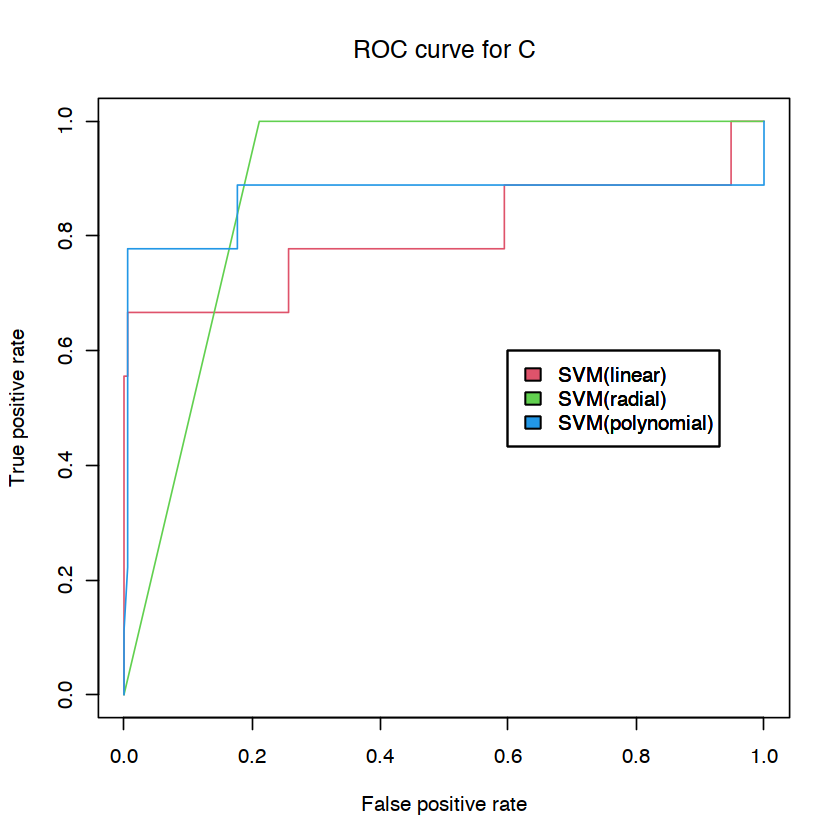

In [346]:
# ROC
ROCs <- vector('list', 4)
# auc
auc <- data.frame(matrix(rep(0, 12), 3, 4, byrow = TRUE))
colnames(auc) <- c('BD', 'H', 'F', 'C')
rownames(auc) <- c('SVM(linear)', 'SVM(radial)', 'SVM(polynomial)')

for(i in 1:4){
    for(j in 1:3){
        # fit each model to each class
        svm.smote = best.models.SMOTE[[j]]
        svm.smote.prob = predict(svm.smote, newdata = test[,-1], 
                                 type = 'prob', probability = TRUE)
        # ROC
        rocr = prediction(attr(svm.smote.prob, "probabilities")[,i], category[[i]])
        perf = performance(rocr, "tpr", "fpr")
        
        # AUC
        auc[j,i] = performance(rocr, "auc")@y.values
        
        # plots
        if(j == 1){
            ROC = plot(perf, col = j+1, main = paste("ROC curve for", variable[i]))
        }else{
            ROC = plot(perf, col = j+1, add = TRUE)
        }
        legend(0.6, 0.6, c('SVM(linear)', 'SVM(radial)', 'SVM(polynomial)'), 2:5)
    }
    ROCs[[i]] <- ROC
}

In [347]:
auc

,BD,H,F,C
,<dbl>,<dbl>,<dbl>,<dbl>
SVM(linear),0.9304153,0.7417272,0.7528090,0.7993651
SVM(radial),0.9088103,0.8970944,0.8707865,0.8942857
SVM(polynomial),0.9417789,0.8595642,0.8876404,0.8657143
